# All Data EDA

Description of data cleaning before this file:

1. Load and combine credit rating datasets to get unique ratings, company/tickers, and rating issue dates (unique key is credit rating, rating agency, and issuance date). Limit to S&P ratings from 2010-2016.
2. Load dataset of earnings call transcripts, dates, year + quarter of statement releases, companies, and sectors (unique key is company by earnings call date).
3. Load tabular financial statement datasets (unique key is company, year, quarter).
4. Use earnings call dates to transform dataset of credit ratings so there is one rating at each earnings call date. The key assumption is that a rating stays the same until a new rating is issued. Use leads to get rating at next earnings call date, date of next earnings call, rating 2 earnings call dates ahead, and date of that earnings call.
5. Inner join earnings call data with credit rating data. Use year and quarter from earnings calls to inner join with financial statement data. This produces the `all_data` dataset.

# Setup - Sample Path and Packages

In [1]:
# Flag for if you are running this on the sample dataset
# Sample comprises 100 earnings calls (transcripts included)
# Full data comprises 4532 earnings calls (transcripts included)
sample = False
# Modify this path as needed to run on your machine
sample_path = r'~\Box\STAT 222 Capstone\Intermediate Data\all_data_sample.csv'

In [2]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt

# Code

In [3]:
# Load in sample csv, or full parquet file
# Use inputted sample path, or ~\Box\STAT 222 Capstone\Intermediate Data\all_data.parquet
if sample:
    df = pd.read_csv(sample_path)
else:
    df = pd.read_parquet(r'~\Box\STAT 222 Capstone\Intermediate Data\all_data.parquet') 
df

,ticker,earnings_call_date,next_earnings_call_date,rating_on_next_earnings_call_date,days_until_next_earnings_call,Rating,Rating Agency Name,rating_date,Source,Rating Rank AAA is 10,...,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,link_income_statement,finalLink_income_statement,Rating on Next Earnings Call Date Rank AAA is 10,Change Direction Before Next Call,Change Before Next Call
0,ABBV,2014-07-25,2014-10-31,A,98.0,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,...,0.222899,0.69,0.68,1.594000e+09,1.608000e+09,https://www.sec.gov/Archives/edgar/data/155115...,https://www.sec.gov/Archives/edgar/data/155115...,8.0,Same At Next Call,0.0
1,ABBV,2014-10-31,2015-01-30,A,91.0,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,...,0.100817,0.32,0.31,1.595000e+09,1.610000e+09,https://www.sec.gov/Archives/edgar/data/155115...,https://www.sec.gov/Archives/edgar/data/155115...,8.0,Same At Next Call,0.0
2,ABBV,2015-01-30,2015-04-23,A,83.0,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,...,-0.148569,-0.51,-0.51,1.591389e+09,1.597000e+09,https://www.sec.gov/Archives/edgar/data/155115...,https://www.sec.gov/Archives/edgar/data/155115...,8.0,Same At Next Call,0.0
3,ABBV,2015-04-23,2015-07-24,A,92.0,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,...,0.202778,0.64,0.63,1.595000e+09,1.608000e+09,https://www.sec.gov/Archives/edgar/data/155115...,https://www.sec.gov/Archives/edgar/data/155115...,8.0,Same At Next Call,0.0
4,ABBV,2015-07-24,2015-10-30,A,98.0,A,Standard & Poor's Ratings Services,2014-07-18,Original,8,...,0.249498,0.84,0.83,1.620000e+09,1.633000e+09,https://www.sec.gov/Archives/edgar/data/155115...,https://www.sec.gov/Archives/edgar/data/155115...,8.0,Same At Next Call,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4527,ZTS,2015-11-03,2016-02-16,BBB,105.0,BBB,Standard & Poor's Ratings Services,2015-11-03,Supplementary,7,...,0.175559,0.41,0.41,4.973990e+08,4.995390e+08,https://www.sec.gov/Archives/edgar/data/155528...,https://www.sec.gov/Archives/edgar/data/155528...,7.0,Same At Next Call,0.0
4528,ZTS,2016-02-16,2016-05-04,BBB,78.0,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,...,0.185430,0.45,0.45,4.963000e+08,4.988000e+08,https://www.sec.gov/Archives/edgar/data/155528...,https://www.sec.gov/Archives/edgar/data/155528...,7.0,Same At Next Call,0.0
4529,ZTS,2016-05-04,2016-08-03,BBB,91.0,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,...,0.192587,0.48,0.48,4.952000e+08,4.979000e+08,https://www.sec.gov/Archives/edgar/data/155528...,https://www.sec.gov/Archives/edgar/data/155528...,7.0,Same At Next Call,0.0
4530,ZTS,2016-08-03,2016-11-02,BBB,91.0,BBB,Standard & Poor's Ratings Services,2016-01-22,Both,7,...,0.120595,0.31,0.31,4.939320e+08,4.966380e+08,https://www.sec.gov/Archives/edgar/data/155528...,https://www.sec.gov/Archives/edgar/data/155528...,7.0,Same At Next Call,0.0


In [4]:
## summary of the raw data 

# Summarize all numeric columns
# use describe method, transpose, and print all rows
# round to two decimal places, no scientific notation, commas for thousands
pd.options.display.float_format = '{:,.2f}'.format
# pandas setting to display all rows
pd.set_option('display.max_rows', None)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
days_until_next_earnings_call,"4,213.00",93.27,24.64,26.00,88.00,91.00,96.00,840.00
Rating Rank AAA is 10,"4,532.00",6.75,1.28,2.00,6.00,7.00,8.00,10.00
Change in Rating,"3,587.00",0.02,0.53,-2.00,0.00,0.00,0.00,3.00
Year,"4,532.00","2,013.28",1.64,"2,010.00","2,012.00","2,013.00","2,015.00","2,016.00"
year,"4,532.00","2,014.29",1.57,"2,010.00","2,013.00","2,015.00","2,016.00","2,019.00"
quarter,"4,532.00",2.52,1.12,1.00,2.00,3.00,4.00,4.00
cik,"4,532.00","709,311.50","549,506.65","1,800.00","75,677.00","833,079.00","1,101,239.00","1,841,666.00"
calendarYear,"4,532.00","2,014.29",1.57,"2,010.00","2,013.00","2,015.00","2,016.00","2,019.00"
period,"4,532.00",2.52,1.12,1.00,2.00,3.00,4.00,4.00
cashAndCashEquivalents,"4,532.00","1,535,929,224.37","5,523,419,258.67",0.00,"133,942,000.00","432,800,000.00","1,367,546,250.00","145,144,000,000.00"


Note: currently investigating issues with year variables being outside of the desired range of the data.

Also need to investigate financial statement variables in quadrillions, trillions, etc. and how to handle them.

In [5]:
# Revert to default settings
pd.reset_option('display.float_format')
pd.reset_option('display.max_rows')

In [6]:
# Check data is unique on ticker by earnings_call_date
df['ticker_earnings_date'] = df['ticker'] + '_' + df['earnings_call_date'].astype(str)
df['ticker_earnings_date'].value_counts().max()

1

In [7]:
# Number of unique firms (identified by ticker)
df['ticker'].nunique()

319

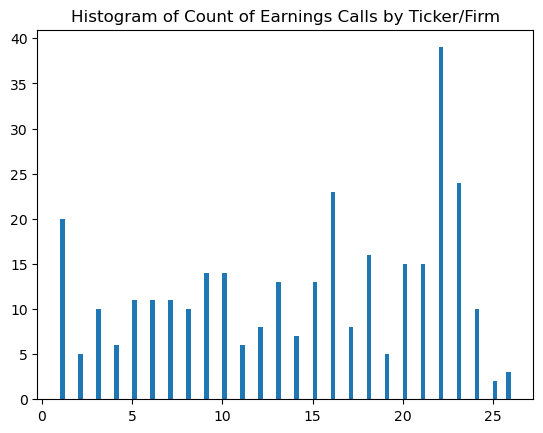

In [8]:
# Histogram of count of earnings calls by ticker/firm
# Title: Histogram of Count of Earnings Calls by Ticker
plt.hist(df['ticker'].value_counts(), bins = 100)
plt.title('Histogram of Count of Earnings Calls by Ticker/Firm')
plt.show()

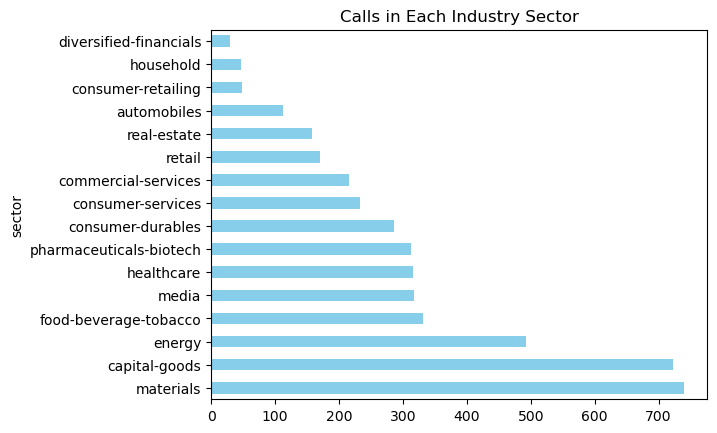

In [9]:
# Distribution of industry sectors
# variable sector
# Title: Calls in Each Industry Sector
df['sector'].value_counts().plot(kind = 'barh', color = 'skyblue')
plt.title('Calls in Each Industry Sector')
plt.show()

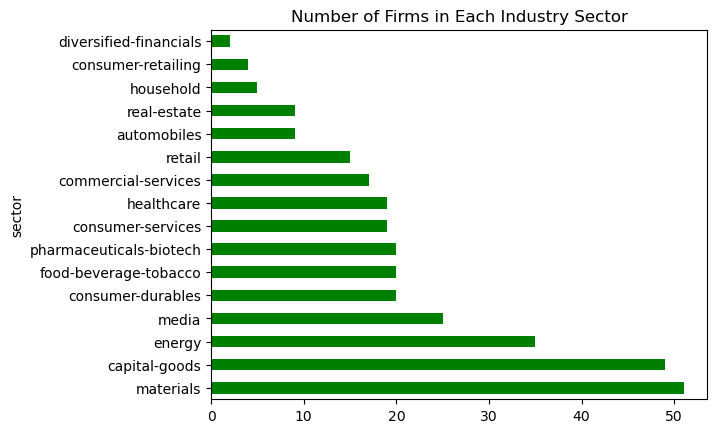

In [10]:
# Number of firms in each industry sector
# Title: Number of Firms in Each Industry Sector
# Unique ticker by sector, sort by number of firms
df.groupby('sector')['ticker'].nunique().sort_values(ascending=False).plot(kind = 'barh', color = 'green')
plt.title('Number of Firms in Each Industry Sector')
plt.show()

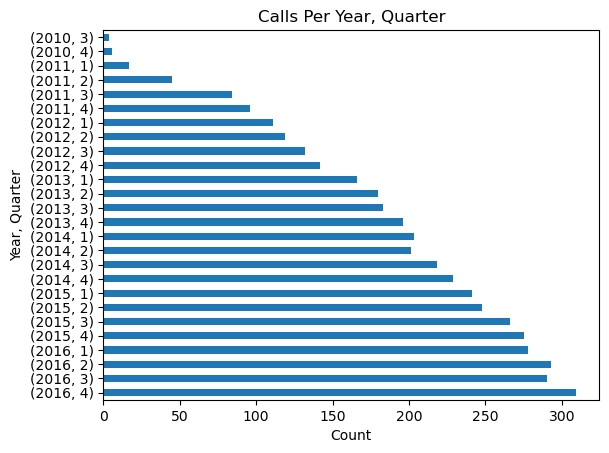

In [11]:
# Distribution of earnings_call_date
# Create call_year and call_quarter columns after converting earnings_call_date to datetime
df['call_year'] = pd.to_datetime(df['earnings_call_date']).dt.year
df['call_quarter'] = pd.to_datetime(df['earnings_call_date']).dt.quarter
# Group by year and quarter
data_grouped = df.groupby([df.call_year, df.call_quarter]).size().sort_index(ascending=False)
# Plot horizontal bar chart
# 2010 at the top
data_grouped.plot(kind='barh')
plt.title('Calls Per Year, Quarter')
plt.xlabel('Count')
plt.ylabel('Year, Quarter')
plt.show()


In [12]:
# Company dropout
# For each ticker, get the max value of earnings_call_date, and print out items where it is not in the last quarter of 2016
# Convert earnings_call_date to datetime
df['earnings_call_date_dt'] = pd.to_datetime(df['earnings_call_date'])
# Add column max_date to df
df['max_date'] = df.groupby('ticker')['earnings_call_date_dt'].transform('max')
# Display rows where max_date is not in the last quarter of 2016
df[df['max_date'] < '2016-10-01']

,ticker,earnings_call_date,next_earnings_call_date,rating_on_next_earnings_call_date,days_until_next_earnings_call,Rating,Rating Agency Name,rating_date,Source,Rating Rank AAA is 10,...,link_income_statement,finalLink_income_statement,Rating on Next Earnings Call Date Rank AAA is 10,Change Direction Before Next Call,Change Before Next Call,ticker_earnings_date,call_year,call_quarter,earnings_call_date_dt,max_date
143,AMCR,2016-08-25,None,None,NaN,BBB,Standard & Poor's Ratings Services,2016-03-23,Supplementary,7,...,https://www.sec.gov/Archives/edgar/data/174879...,https://www.sec.gov/Archives/edgar/data/174879...,NaN,None,NaN,AMCR_2016-08-25,2016,3,2016-08-25,2016-08-25
495,BTU,2011-10-25,2012-04-19,BB,177.0,BB,Standard & Poor's Ratings Services,2011-08-31,Supplementary,6,...,https://www.sec.gov/Archives/edgar/data/106472...,https://www.sec.gov/Archives/edgar/data/106472...,6.0,Same At Next Call,0.0,BTU_2011-10-25,2011,4,2011-10-25,2016-02-11
496,BTU,2012-04-19,2012-07-24,BB,96.0,BB,Standard & Poor's Ratings Services,2011-08-31,Supplementary,6,...,https://www.sec.gov/Archives/edgar/data/106472...,https://www.sec.gov/Archives/edgar/data/106472...,6.0,Same At Next Call,0.0,BTU_2012-04-19,2012,2,2012-04-19,2016-02-11
497,BTU,2012-07-24,2012-10-22,B,90.0,BB,Standard & Poor's Ratings Services,2011-08-31,Supplementary,6,...,https://www.sec.gov/Archives/edgar/data/106472...,https://www.sec.gov/Archives/edgar/data/106472...,5.0,Downgrade Before Next Call,-1.0,BTU_2012-07-24,2012,3,2012-07-24,2016-02-11
498,BTU,2012-10-22,2013-01-29,B,99.0,B,Standard & Poor's Ratings Services,2012-08-31,Supplementary,5,...,https://www.sec.gov/Archives/edgar/data/106472...,https://www.sec.gov/Archives/edgar/data/106472...,5.0,Same At Next Call,0.0,BTU_2012-10-22,2012,4,2012-10-22,2016-02-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887,STON,2013-08-07,2013-11-08,B,93.0,B,Standard & Poor's Ratings Services,2013-05-13,Supplementary,5,...,None,None,5.0,Same At Next Call,0.0,STON_2013-08-07,2013,3,2013-08-07,2015-05-08
3888,STON,2013-11-08,2014-03-14,B,126.0,B,Standard & Poor's Ratings Services,2013-09-11,Supplementary,5,...,None,None,5.0,Same At Next Call,0.0,STON_2013-11-08,2013,4,2013-11-08,2015-05-08
3889,STON,2014-03-14,2014-05-08,B,55.0,B,Standard & Poor's Ratings Services,2014-03-06,Supplementary,5,...,None,None,5.0,Same At Next Call,0.0,STON_2014-03-14,2014,1,2014-03-14,2015-05-08
3890,STON,2014-05-08,2015-05-08,B,365.0,B,Standard & Poor's Ratings Services,2014-03-06,Supplementary,5,...,None,None,5.0,Same At Next Call,0.0,STON_2014-05-08,2014,2,2014-05-08,2015-05-08


In [13]:
# Unique firms where this is the case
df[df['max_date'] < '2016-10-01'][['ticker', 'max_date']].drop_duplicates()

,ticker,max_date
143,AMCR,2016-08-25
495,BTU,2016-02-11
1598,FTI,2016-04-30
2257,KBH,2016-09-21
2687,MKC,2016-09-30
2742,MOS,2016-08-02
3056,NUE,2016-07-22
3267,PEP,2016-09-29
3318,PKG,2016-07-21
3496,RFP,2016-08-06


AMCR is amcor, should still exist but it's date is kind of close to the end of 2016

BTU, peabody energy, seems to have gone bankrupt April 13, 2016

FTI underwent a merger in 2016-2017

KBH still exists, but again the date is pretty close...

The other non-close one is STON. Notably, StonMor Partners had some issues with delayed SEC filings https://seekingalpha.com/article/4056108-prelude-to-bankruptcy-saving-grace-stonemor-partners-delays-10-k-again

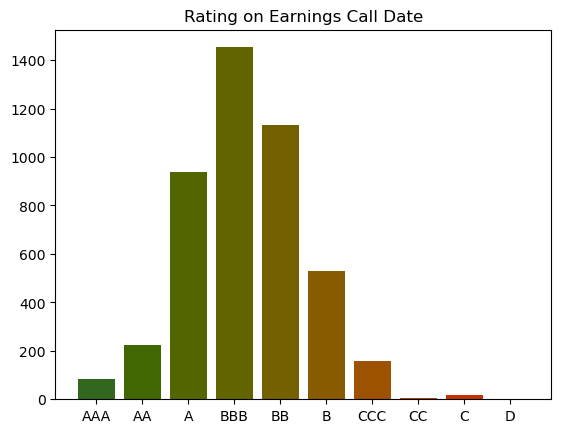

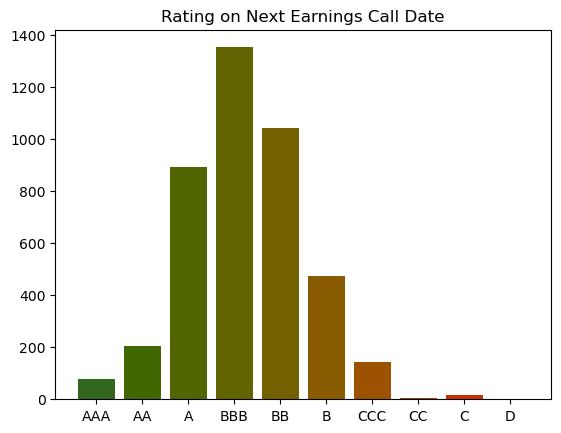

In [14]:
# Distribution of Rating and rating_on_next_earnings_call_date

# Colored with gradient and ordered

# Colors AAA through D
# Used https://colordesigner.io/gradient-generator#google_vignette
# Assign hex codes from green to red
#32671d
#416703
#516600
#626400
#756000
#885b00
#9c5200
#af4500
#c33200
#d60000
hex_code_mapper = {'AAA': '#32671d', 'AA': '#416703', 'A': '#516600', 'BBB': '#626400', 'BB': '#756000', 'B': '#885b00', 'CCC': '#9c5200', 'CC': '#af4500', 'C': '#c33200', 'D': '#d60000'}

# Ordering of bars - keys from hex_code_mapper
bar_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
# Assign values of Rating to this ordering
df['Rating'] = pd.Categorical(df['Rating'], categories=bar_order, ordered=True)

# Create plot
# Save to "../Output/Distribution of Ratings.png"
plt.bar(df['Rating'].value_counts().sort_index().index, df['Rating'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
plt.title('Rating on Earnings Call Date')
#plt.savefig('../../Output/Distribution of Rating Issuances.png')
plt.show()

# Rating on next earnings call date
df['rating_on_next_earnings_call_date'] = pd.Categorical(df['rating_on_next_earnings_call_date'], categories=bar_order, ordered=True)
plt.bar(df['rating_on_next_earnings_call_date'].value_counts().sort_index().index, df['rating_on_next_earnings_call_date'].value_counts().sort_index(), color=[hex_code_mapper[i] for i in bar_order])
plt.title('Rating on Next Earnings Call Date')
#plt.savefig('../../Output/Distribution of Rating on Next Earnings Call Date.png')
plt.show()

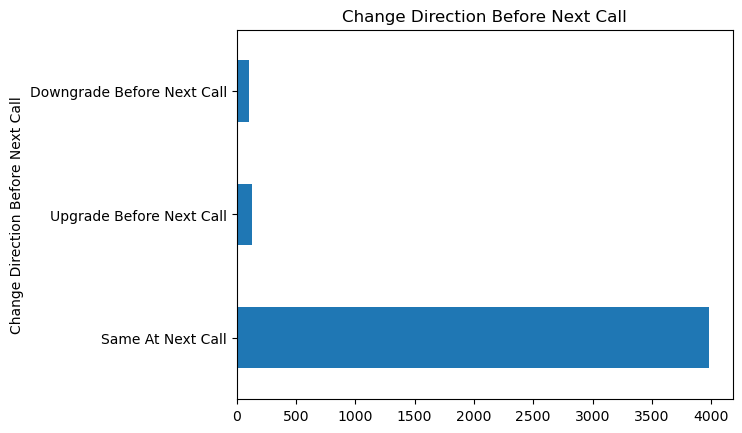

Change Direction Before Next Call
Same At Next Call             3981
Upgrade Before Next Call       130
Downgrade Before Next Call     102
Name: count, dtype: int64


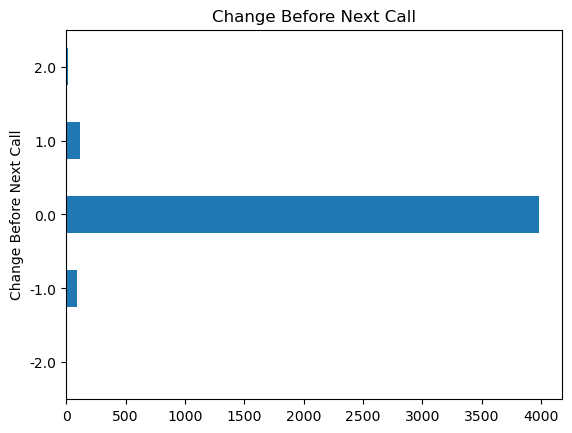

Change Before Next Call
-2.0       9
-1.0      93
 0.0    3981
 1.0     117
 2.0      13
Name: count, dtype: int64


In [15]:
# Bar chart of 'Change Direction Before Next Call'
df['Change Direction Before Next Call'].value_counts().plot(kind='barh')
plt.title('Change Direction Before Next Call')
plt.show()
print(df['Change Direction Before Next Call'].value_counts())

# Bar chart of 'Change Before Next Call'
df['Change Before Next Call'].value_counts().sort_index().plot(kind='barh')
plt.title('Change Before Next Call')
plt.show()
print(df['Change Before Next Call'].value_counts().sort_index())


C:\Users\ijyli\AppData\Local\Temp\ipykernel_11612\3119831694.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()


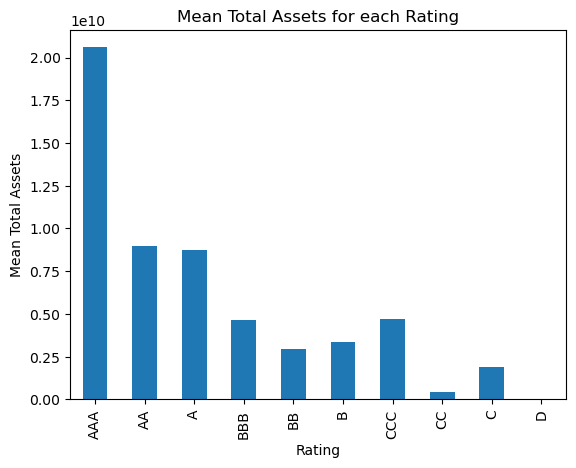

In [16]:
# Calculate the mean of "totalAssets" for each kind of "Rating"
mean_assets_by_rating = df.groupby('Rating')['totalDebt'].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Total Assets for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Total Assets')
plt.show()

C:\Users\ijyli\AppData\Local\Temp\ipykernel_11612\796684613.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()


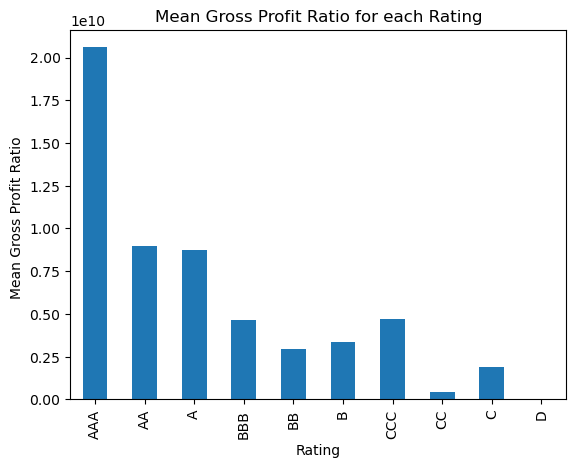

In [17]:
# Calculate the mean of "grossProfitRatio" for each kind of "Rating"
mean_gross_profit_by_rating = df.groupby('Rating')["grossProfitRatio"].mean()

# Plotting
mean_assets_by_rating.plot(kind='bar')
plt.title('Mean Gross Profit Ratio for each Rating')
plt.xlabel('Rating')
plt.ylabel('Mean Gross Profit Ratio ')
plt.show()

We can see the relationship between rating and total assets; rating and gross profit ratio. High rating like AAA will have high mean total assets and high mean gross profit ratio.

# NLP EDA

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

# Basic Statistics
num_records = len(df)
avg_length = df['transcript'].str.len().mean()

print(f"Number of records: {num_records}")
print(f"Average transcript length: {avg_length:.2f} characters")

Number of records: 4532
Average transcript length: 51412.94 characters


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ijyli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ijyli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


average number of sentences: 471.74073256840245
average sentence length: 21.759816158534733
Top 10 most common words:
quarter: 248253
year: 220870
think: 187990
million: 158704
business: 126889
growth: 122016
going: 108995
would: 108204
first: 96107
us: 95476


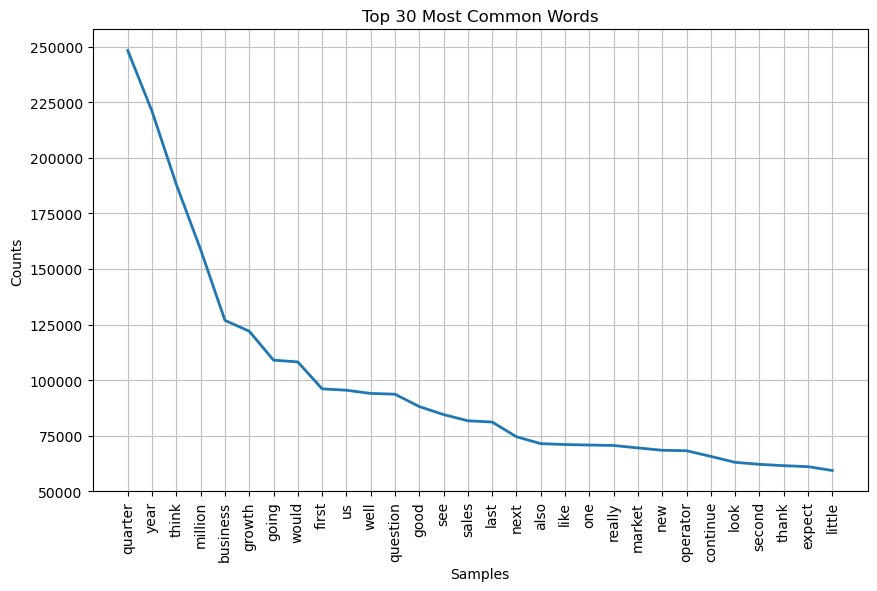

<Axes: title={'center': 'Top 30 Most Common Words'}, xlabel='Samples', ylabel='Counts'>

In [19]:
# Tokenize the text
nltk.download('punkt')  # Download NLTK tokenizer data
tokens = df['transcript'].apply(word_tokenize)

# Remove stop words
nltk.download('stopwords')  # Download NLTK stop words data
stop_words = set(stopwords.words('english'))
tokens = tokens.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words and word.isalpha()])

# Number of sentences
sentences = df['transcript'].apply(nltk.sent_tokenize)
num_sentences = sentences.apply(len)
print('average number of sentences:', num_sentences.mean())

# Sentence length
sentence_lengths = sentences.apply(lambda x: [len(word_tokenize(sentence)) for sentence in x])
sentence_lengths = sentence_lengths.explode()
print('average sentence length:', sentence_lengths.mean())

# Word Frequency Analysis
all_words = [word.lower() for token_list in tokens for word in token_list]
fdist = FreqDist(all_words)
top_words = fdist.most_common(10)
print("Top 10 most common words:")
for word, freq in top_words:
    print(f"{word}: {freq}")

# Plot Word Frequency Distribution
plt.figure(figsize=(10, 6))
fdist.plot(30, title='Top 30 Most Common Words')

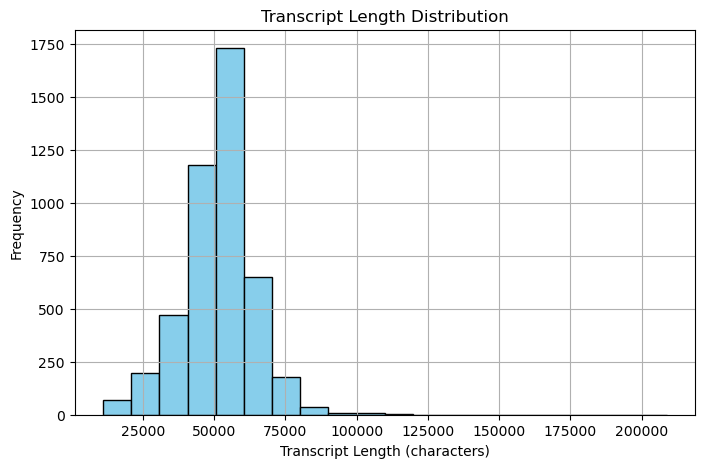

In [20]:
# Text Length Distribution
transcript_lengths = df['transcript'].str.len()
plt.figure(figsize=(8, 5))
plt.hist(transcript_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Transcript Length Distribution')
plt.xlabel('Transcript Length (characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

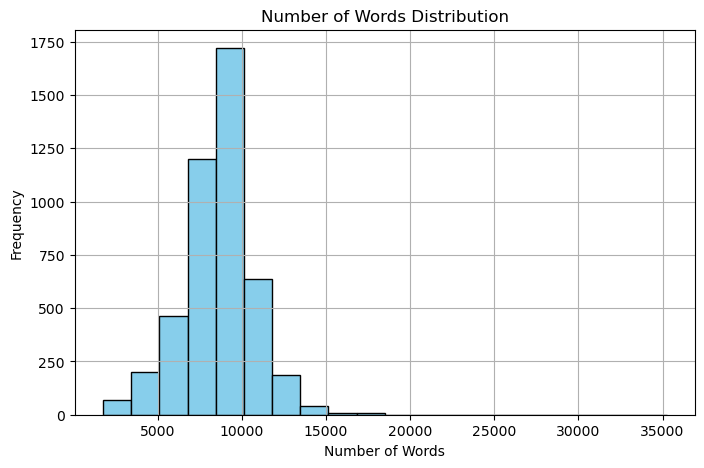

Average transcript length in words: 8612.410635481025


In [21]:
# Distribution of Number of Words in earning calls 
def count_words(tokens):
    tokens = [word.lower() for word in tokens if word.isalpha()]
    return len(tokens)

word_tokens = df['transcript'].apply(word_tokenize)
num_words = word_tokens.apply(count_words)
plt.figure(figsize=(8, 5))
plt.hist(num_words, bins=20, color='skyblue', edgecolor='black')
plt.title('Number of Words Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print('Average transcript length in words:', num_words.mean())

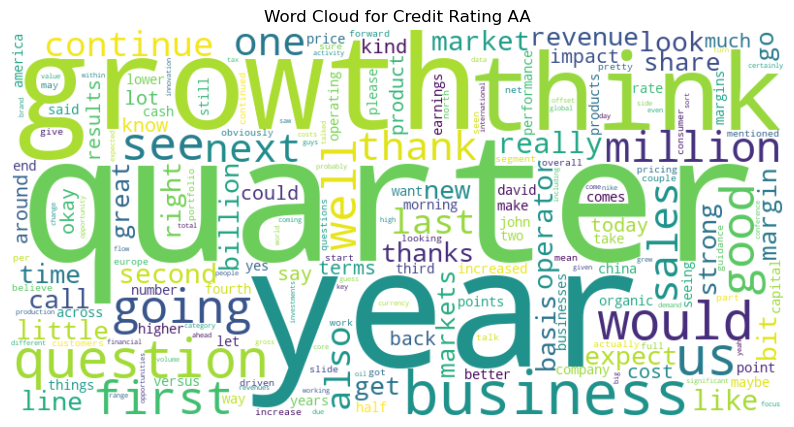

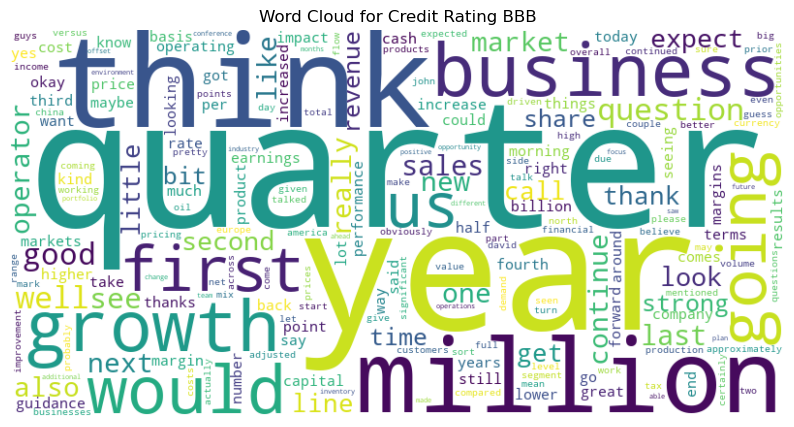

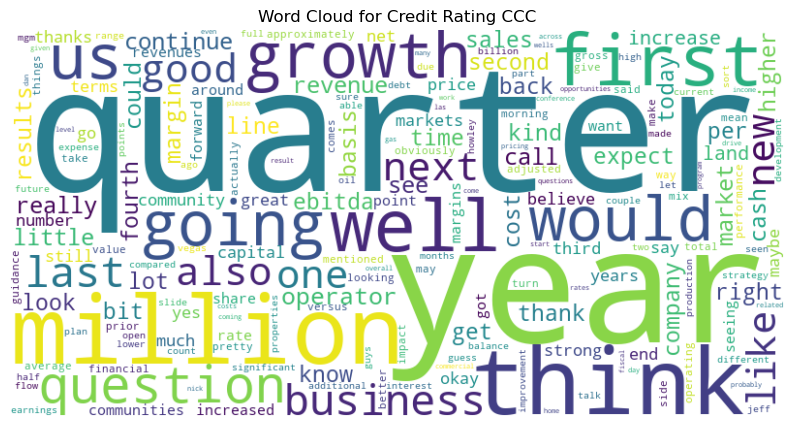

In [22]:
from wordcloud import WordCloud

# Generate word clouds for each credit rating
ratings = ["AA","BBB","CCC"]
for rating in ratings:

    rating_df = df[df['Rating'] == rating]
    tokens = rating_df['transcript'].apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    tokens = tokens.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words and word.isalpha()])
    
    all_words = [word.lower() for token_list in tokens for word in token_list]
    fdist = FreqDist(all_words)

    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)
    
    # Plot Word Cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Credit Rating {rating}')
    plt.show()

We can see from word cloud for credit rating AA, postive words like "growth" are larger when compared to credit rating CCC.

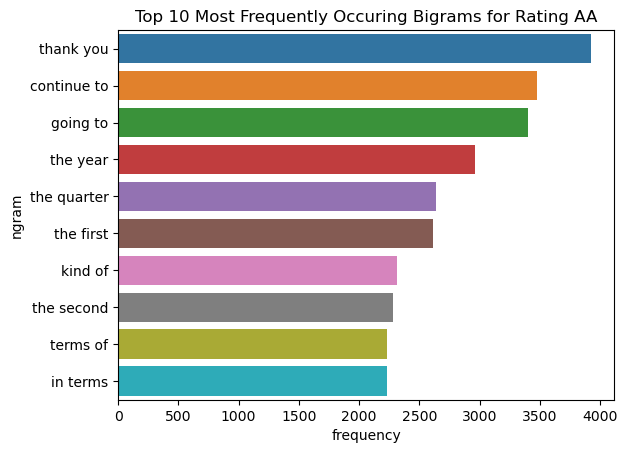

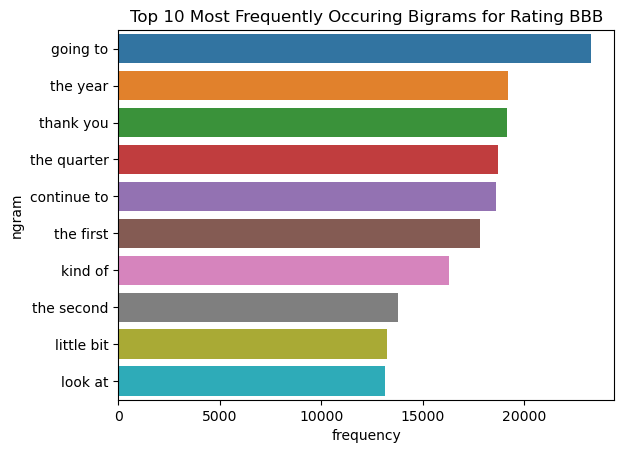

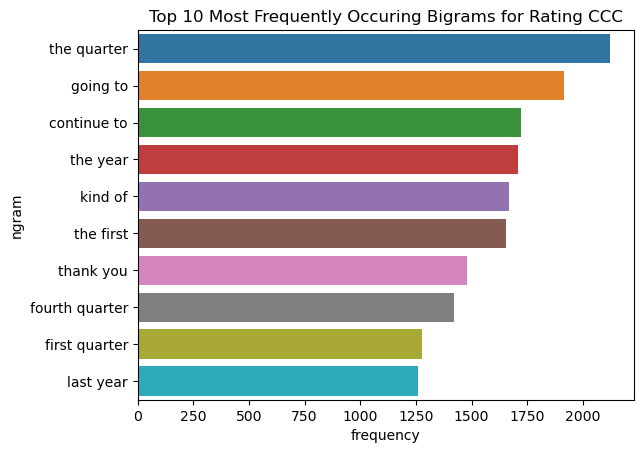

In [24]:
# Bigrams and trigrams
# Generate for each credit rating
ratings = ["AA","BBB","CCC"]
for rating in ratings:

    rating_df = df[df['Rating'] == rating]

    # tokens = rating_df['transcript'].apply(word_tokenize)
    # stop_words = set(stopwords.words('english'))
    # tokens = tokens.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words and word.isalpha()])
    
    # all_words = [word.lower() for token_list in tokens for word in token_list]

    cv = CountVectorizer(ngram_range=(2,2))
    bigrams = cv.fit_transform(rating_df['transcript'])
    count_values = bigrams.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
    # toss out items if they only contain stop words
    ngram_freq = ngram_freq[ngram_freq['ngram'].apply(lambda x: all(word in stop_words for word in x.split())) == False]
    sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
    plt.title('Top 10 Most Frequently Occuring Bigrams for Rating ' + rating)
    plt.show()

    # cv1 = CountVectorizer(ngram_range=(3,3))
    # trigrams = cv1.fit_transform(rating_df['transcript'])
    # count_values = trigrams.toarray().sum(axis=0)
    # ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
    # ngram_freq.columns = ["frequency", "ngram"]
    # # toss out items if they only contain stop words
    # ngram_freq = ngram_freq[ngram_freq['ngram'].apply(lambda x: all(word in stop_words for word in x.split())) == False]
    # sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
    # plt.title('Top 10 Most Frequently Occuring Trigrams for Rating ' + rating)
    # plt.show()

Thank yous become far less common as credit rating deteriorates!

## NER with Spacy - number of companies


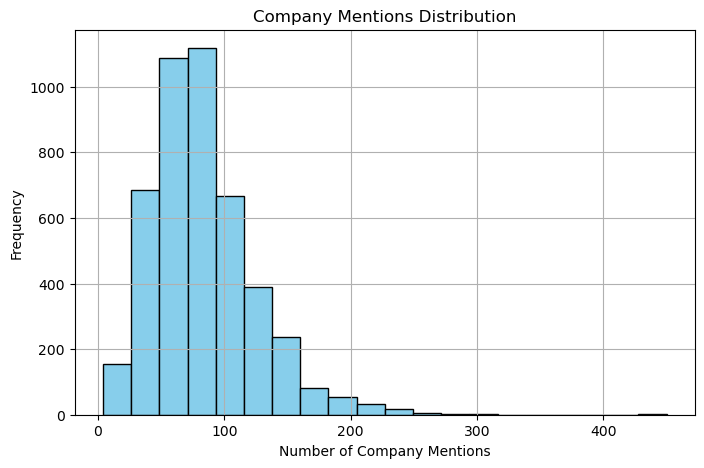

Average number of company mentions: 82.99867608120036


In [25]:
import spacy
from tqdm.auto import tqdm # progress tracking
tqdm.pandas()

# load model and disable unnecessary components
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'lemmatizer', 'attribute_ruler', 'morphologizer', 'textcat'])

# Function to process transcript and count company mentions
def count_companies(text):
    # Process the text
    doc=nlp(text)
    # Counter
    count = 0
    # Initialize count
    for entity in doc.ents:
        # We'll select just entities that are tagged organizations (close enough to companies)
        if entity.label_ == "ORG":
            count += 1
    return count

# Apply the function to the transcript column
df['company_mentions'] = df['transcript'].progress_apply(count_companies)

# Plot the distribution of company mentions
plt.figure(figsize=(8, 5))
plt.hist(df['company_mentions'], bins=20, color='skyblue', edgecolor='black')
plt.title('Company Mentions Distribution')
plt.xlabel('Number of Company Mentions')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print('Average number of company mentions:', df['company_mentions'].mean())

In [26]:
# Testing the nlp model
sample_text = 'Microsoft is a great company. I also like Apple and Google.'
print('testing on sample text:')
print(sample_text)
doc = nlp(sample_text)
for entity in doc.ents:
    print(entity.text, entity.label_)
harder_sample_text = 'I am going to the bank to deposit my money. apple had a great quarter.'
print('testing on harder sample text:')
print(harder_sample_text)
doc = nlp(harder_sample_text)
for entity in doc.ents:
    print(entity.text, entity.label_)

testing on sample text:
Microsoft is a great company. I also like Apple and Google.
Microsoft ORG
Apple ORG
Google ORG
testing on harder sample text:
I am going to the bank to deposit my money. apple had a great quarter.
apple ORG
a great quarter DATE
